# Introduction

## Improting required libraries

In [65]:
# Core libraries for data manipulation
import numpy as np            # For numerical operations
import pandas as pd           # For structured data (DataFrame) manipulation

# Regular expressions for pattern matching
import re

# Visualization libraries
import matplotlib.pyplot as plt   # For basic plotting
import seaborn as sns             # For statistical plots and visual styles

# Dask for out-of-core and parallel data processing (large datasets)
import dask.dataframe as dd

# Glob for file path matching (e.g., loading multiple CSV files at once)
import glob

## Code to check and review each CSV

In [66]:
def eval_df(dataframe):
    """
    Evaluate the structure and quality of a pandas DataFrame.
    
    This function prints:
    - Data types and memory usage
    - Columns with missing values
    - Count of duplicate rows
    - Summary statistics (numeric and categorical)
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The DataFrame to evaluate.
    """
    # Display data types and basic memory usage
    print("\n🔍 DATA TYPES & MEMORY USAGE")
    print("-" * 40)
    print(dataframe.info())

    # Check and display missing values per column
    print("\n🧩 MISSING VALUES PER COLUMN")
    print("-" * 40)
    missing_values = dataframe.isnull().sum()
    print(missing_values[missing_values > 0])

    # Check for duplicate rows
    duplicates = dataframe.duplicated().sum()
    print("\n🗃️ DUPLICATE ROWS FOUND")
    print("-" * 40)
    print(f"{duplicates} duplicate rows found.")

    # Display summary statistics (for both numeric and object types)
    print("\n📊 SUMMARY STATISTICS")
    print("-" * 40)
    print(dataframe.describe())

## Get the sample countries  
- this would include those that have mobility data, policy data, covid data and country statistics data

In [67]:
# To get a common code for the countries I would use the ISO 3166-1 alpha-3
# Load country and country code reference data
COUNTRY_CODE = pd.read_csv("data/country_codes.csv")

# Preview the first few rows
COUNTRY_CODE.head()

,id,alpha2,alpha3,en
0,4,af,afg,Afghanistan
1,8,al,alb,Albania
2,12,dz,dza,Algeria
3,20,ad,and,Andorra
4,24,ao,ago,Angola


In [68]:
len(COUNTRY_CODE)

193

In [69]:
# Capitalise all codes in alpha2 and alpha3
COUNTRY_CODE['alpha2'] = COUNTRY_CODE['alpha2'].str.upper()
COUNTRY_CODE['alpha3'] = COUNTRY_CODE['alpha3'].str.upper() 

In [70]:
COUNTRY_CODE = COUNTRY_CODE.rename(columns = {
    'alpha2': 'code2',
    'alpha3' : 'Code',
    'en' : 'Country'
})

### Get the mobility data

In [71]:
# Columns to include (mobility trends + region info + date)
usecols = [
    "country_region_code", 
    "country_region", 
    "sub_region_1", 
    "sub_region_2", 
    "metro_area",
    "date", 
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"
]

# Explicit dtypes to avoid Dask inference issues
dtype_fix = {
    'sub_region_1': 'object',
    'sub_region_2': 'object',
    'metro_area': 'object',
}

# Load the dataset with parsing and type fixes
df = dd.read_csv(
    'data/global_mobility_report.csv',
    usecols=usecols,
    dtype=dtype_fix,
    parse_dates=['date'],
    assume_missing=True
)

# Filter: only country-level data + dates up to the end of 2022
missing_cols = ['sub_region_1', 'sub_region_2', 'metro_area']
filtered = df[
    df[missing_cols].isnull().all(axis=1) &
    (df['date'] <= '2022-12-31')
]

# Safely preview the filtered result
print(filtered.sample(frac = 0.0001, random_state = 1).compute())

       country_region_code country_region sub_region_1 sub_region_2  \
18274                   AR      Argentina         <NA>         <NA>   
456350                  BJ          Benin         <NA>         <NA>   
109303                  CL          Chile         <NA>         <NA>   
497226                  FR         France         <NA>         <NA>   
19372                   GT      Guatemala         <NA>         <NA>   
160328                  LI  Liechtenstein         <NA>         <NA>   
91450                   KG     Kyrgyzstan         <NA>         <NA>   
268085                  ML           Mali         <NA>         <NA>   
480291                  NP          Nepal         <NA>         <NA>   
533080                  RW         Rwanda         <NA>         <NA>   
450650                  TJ     Tajikistan         <NA>         <NA>   
532980                  US  United States         <NA>         <NA>   
410679                  UY        Uruguay         <NA>         <NA>   

     

In [72]:


# --- New Code to Check Latest Date per Country ---
# Group by country and find the maximum (latest) date for each
latest_dates = filtered.groupby('country_region')['date'].max()

# Compute the result (this triggers the Dask computation)
latest_dates_computed = latest_dates.compute()

# Optional: Sort the results by date to see which countries have the most recent data
print("\n--- Latest Date per Country (Sorted) ---")
print(latest_dates_computed.sort_values(ascending=False))



--- Latest Date per Country (Sorted) ---
country_region
Cambodia     2022-10-15
Sri Lanka    2022-10-15
Slovakia     2022-10-15
Singapore    2022-10-15
Senegal      2022-10-15
                ...    
Benin        2022-10-15
Barbados     2022-10-15
Bangladesh   2022-10-15
Australia    2022-10-15
Ukraine      2022-02-23
Name: date, Length: 135, dtype: datetime64[ns]


In [73]:
# --- New Code to Check Latest Date per Country ---
# Group by country and find the maximum (latest) date for each
latest_dates = filtered.groupby('country_region')['date'].min()

# Compute the result (this triggers the Dask computation)
latest_dates_computed = latest_dates.compute()

# Optional: Sort the results by date to see which countries have the most recent data
print("\n--- Earliest Date per Country (Sorted) ---")
print(latest_dates_computed.sort_values(ascending=False))


--- Earliest Date per Country (Sorted) ---
country_region
Cambodia              2020-02-15
Panama                2020-02-15
Trinidad and Tobago   2020-02-15
Slovakia              2020-02-15
Singapore             2020-02-15
                         ...    
Brazil                2020-02-15
Benin                 2020-02-15
Barbados              2020-02-15
Bangladesh            2020-02-15
Jordan                2020-02-15
Name: date, Length: 135, dtype: datetime64[ns]


In [74]:
# I woul like to get what happened in the first two years of the pandemic
filtered = filtered[
    filtered['date'] <= '2022-02-15'
]

In [75]:
print(filtered.sample(frac = 0.0001, random_state = 1).compute())

       country_region_code      country_region sub_region_1 sub_region_2  \
35060                   AU           Australia         <NA>         <NA>   
177745                  CM            Cameroon         <NA>         <NA>   
157822                  DO  Dominican Republic         <NA>         <NA>   
212703                  HU             Hungary         <NA>         <NA>   
130970                  LB             Lebanon         <NA>         <NA>   
266250                  MD             Moldova         <NA>         <NA>   
58358                   PT            Portugal         <NA>         <NA>   
431777                  SV         El Salvador         <NA>         <NA>   
430657                  VE           Venezuela         <NA>         <NA>   

       metro_area       date  \
35060        <NA> 2021-10-18   
177745       <NA> 2021-06-21   
157822       <NA> 2020-12-05   
212703       <NA> 2021-12-07   
130970       <NA> 2020-07-17   
266250       <NA> 2022-01-26   
58358        <N

In [76]:

# rename country_region_code and country_region
filtered = filtered.rename(columns = {
    'country_region_code' : 'code2',
    'country_region' : 'Country'
})


In [77]:
# get a dataframe for the unique countries in the mobility data
countries_in_mob = filtered[['code2', 'Country']].drop_duplicates().compute()
countries_in_mob

,code2,Country
308409,BA,Bosnia and Herzegovina
547709,JO,Jordan
161748,LT,Lithuania
222006,LU,Luxembourg
253027,LY,Libya
...,...,...
53823,KE,Kenya
317749,MY,Malaysia
578462,NL,Netherlands
242319,PY,Paraguay


In [78]:
# check if there are missing
countries_in_mob[countries_in_mob['code2'].isna()]

,code2,Country
355842,<NA>,Namibia


Python has read NA code for Nambia as an empty cell

In [79]:
# Create the condition
condition = (filtered['Country'] == 'Namibia') & (filtered['code2'].isna())

# Use .where to replace values where the condition is False
# This means: keep 'code2' where condition is False, otherwise use 'NA'
# Note: .where keeps the original where the condition is FALSE, and replaces where it's TRUE
# So we need to negate the condition for .where, or use .mask
# .mask is the opposite of .where: it replaces where the condition is TRUE
filtered['code2'] = filtered['code2'].mask(condition, 'NA')

In [80]:
# get a dataframe for the unique countries in the mobility data
countries_in_mob = filtered[['code2', 'Country']].drop_duplicates().compute()
# check if there are missing
countries_in_mob[countries_in_mob['code2'].isna()]

,code2,Country


In [81]:
# Get unique code2 that is in countries_in_mob but not in COUNTRY_CODE
not_in_cc = np.setdiff1d(countries_in_mob['code2'].unique(), COUNTRY_CODE['code2'].unique())
not_in_cc


array(['AW', 'HK', 'PR', 'RE', 'TW'], dtype=object)

In [82]:
countries_in_mob[countries_in_mob['code2'].isin(not_in_cc)]

,code2,Country
307435,AW,Aruba
261599,RE,Réunion
128171,HK,Hong Kong
498936,PR,Puerto Rico
460440,TW,Taiwan


In [83]:
# Check if there are items Country in countries_in_mob and COUNTRY_CODE that have the same code2 but different name

All of the five are either not a country, not a soverign nation, or not recognised as independent so for this analysis I would remove them for now

In [84]:
# Check if there are items in countries_in_mob and COUNTRY_CODE that have the same 'code2' but different 'Country' names

# Perform an inner join on 'code2' to find matching codes
merged_check = countries_in_mob[['code2', 'Country']].merge(
    COUNTRY_CODE[['code2', 'Country']],
    on='code2',
    how='inner',
    suffixes=('_mob', '_cc')  # Add suffixes to distinguish the 'Country' columns
)

# Filter for rows where the country names are different
mismatched_names = merged_check[merged_check['Country_mob'] != merged_check['Country_cc']]

# Display the results
if not mismatched_names.empty:
    print("Found entries with the same 'code2' but different 'Country' names:")
    print(mismatched_names[['code2', 'Country_mob', 'Country_cc']])
else:
    print("No entries found with the same 'code2' but different 'Country' names.")

Found entries with the same 'code2' but different 'Country' names:
    code2      Country_mob                                         Country_cc
9      MD          Moldova                               Moldova, Republic of
20     VE        Venezuela                  Venezuela, Bolivarian Republic of
24     BO          Bolivia                    Bolivia, Plurinational State of
28     TZ         Tanzania                       Tanzania, United Republic of
30     GB   United Kingdom  United Kingdom of Great Britain and Northern I...
38     LA             Laos                   Lao People's Democratic Republic
60     VN          Vietnam                                           Viet Nam
68     MM  Myanmar (Burma)                                            Myanmar
76     TR           Turkey                                            Türkiye
86     KR      South Korea                                 Korea, Republic of
100    BS      The Bahamas                                            Baham

In [85]:
COUNTRY_CODE.head(10)

,id,code2,Code,Country
0,4,AF,AFG,Afghanistan
1,8,AL,ALB,Albania
2,12,DZ,DZA,Algeria
3,20,AD,AND,Andorra
4,24,AO,AGO,Angola
5,28,AG,ATG,Antigua and Barbuda
6,32,AR,ARG,Argentina
7,51,AM,ARM,Armenia
8,36,AU,AUS,Australia
9,40,AT,AUT,Austria


Based on the output, the countries are the same

In [86]:
# create a version of the COUNTRY_CODE the has no country to be merged to the filtered dask dataframe
country_code_wo_country = COUNTRY_CODE[['code2', 'Code']]

# merge the COUNTRY_CODE to the filtered dataframe to add the three letter code
filtered_mobility = dd.merge(
    filtered,
    country_code_wo_country,
    on = 'code2',
    how = 'left'
)

# Get a dataframe for the unique countries in the mobility data, excluding rows with <NA> in 'code2'
countries_in_mob = (
    filtered_mobility[['Code', 'Country']]
    .drop_duplicates()
    .dropna(subset=['Code'])  # Remove rows where 'code2' is <NA>
    .compute()
)

countries_in_mob


,Code,Country
2877,ARG,Argentina
2883,GNB,Guinea-Bissau
732,ITA,Italy
5856,TUR,Turkey
2196,UKR,Ukraine
...,...,...
2193,POL,Poland
0,ARE,United Arab Emirates
3609,AUT,Austria
732,KEN,Kenya


In [87]:
# remove duplicates, and sort the results alphabetically by Country
result = (
    filtered_mobility[['code2', 'Code', 'Country']]
    .drop_duplicates()
    .compute()
    .sort_values(by='Country')  # Sort alphabetically by the 'Country' column
)

result.style.set_table_attributes(
    'style="height:300px; overflow-y:scroll; display:block;"'
)

,code2,Code,Country
732,AF,AFG,Afghanistan
2145,AO,AGO,Angola
1419,AG,ATG,Antigua and Barbuda
2877,AR,ARG,Argentina
732,AW,,Aruba
0,AU,AUS,Australia
3609,AT,AUT,Austria
5856,BH,BHR,Bahrain
2928,BD,BGD,Bangladesh
2196,BB,BRB,Barbados


In [88]:
# It seems that there might be missing code
result[result['Code'].isna()]

,code2,Code,Country
732,AW,<NA>,Aruba
3590,HK,<NA>,Hong Kong
2925,PR,<NA>,Puerto Rico
2196,RE,<NA>,Réunion
732,TW,<NA>,Taiwan


In [89]:
print(filtered_mobility.sample(frac = 0.0001, random_state = 1).compute())

      code2             Country sub_region_1 sub_region_2 metro_area  \
611      AU           Australia         <NA>         <NA>       <NA>   
2688     CM            Cameroon         <NA>         <NA>       <NA>   
1758     DO  Dominican Republic         <NA>         <NA>       <NA>   
7179     HU             Hungary         <NA>         <NA>       <NA>   
6009     LB             Lebanon         <NA>         <NA>       <NA>   
12385    MD             Moldova         <NA>         <NA>       <NA>   
184      PT            Portugal         <NA>         <NA>       <NA>   
3020     SV         El Salvador         <NA>         <NA>       <NA>   
1044     VE           Venezuela         <NA>         <NA>       <NA>   

            date  retail_and_recreation_percent_change_from_baseline  \
611   2021-10-18                                              -15.0    
2688  2021-06-21                                                6.0    
1758  2020-12-05                                              -

In [90]:
# Drop unnecessary columns in filtered_mobility
filtered_mobility = filtered_mobility.drop(columns = [
    'code2',
    'sub_region_1',
    'sub_region_2',
    'metro_area'
], axis = 1)

# Rename columns to be shorter
filtered_mobility = filtered_mobility.rename(columns = {
    'retail_and_recreation_percent_change_from_baseline' : 'retail_and_recreation',
    'grocery_and_pharmacy_percent_change_from_baseline' : 'grocery_and_pharmacy',
    'parks_percent_change_from_baseline' : 'parks',
    'transit_stations_percent_change_from_baseline' : 'transit_stations',
    'workplaces_percent_change_from_baseline' : 'workplaces',
    'residential_percent_change_from_baseline' : 'residential',
    'date' : 'Date'
})

print(filtered_mobility.sample(frac = 0.0001, random_state = 1).compute())

                  Country       Date  retail_and_recreation  \
611             Australia 2021-10-18                  -15.0   
2688             Cameroon 2021-06-21                    6.0   
1758   Dominican Republic 2020-12-05                  -29.0   
7179              Hungary 2021-12-07                    7.0   
6009              Lebanon 2020-07-17                  -10.0   
12385             Moldova 2022-01-26                  -14.0   
184              Portugal 2020-08-17                   -1.0   
3020          El Salvador 2020-05-17                  -82.0   
1044            Venezuela 2020-12-23                    6.0   

       grocery_and_pharmacy  parks  transit_stations  workplaces  residential  \
611                     6.0  -17.0             -53.0       -18.0          9.0   
2688                   33.0  -11.0              35.0       -12.0         -2.0   
1758                   -4.0  -32.0             -23.0       -17.0          8.0   
7179                   24.0   22.0           

### Get national policy

In [91]:
# Check the oxford covid19 government response tracker
national_policy = pd.read_csv('data/oxcgt.csv')
national_policy.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,V3_Vaccine Financial Support (summary),V4_Mandatory Vaccination (summary),ConfirmedCases,ConfirmedDeaths,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0,NaN,0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0,NaN,0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0,NaN,0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0,NaN,0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0,NaN,0,NaN,...,0,NaN,0.0,0.0,NV,0.0,0.0,0.0,0.0,0.0


In [92]:
eval_df(national_policy)


🔍 DATA TYPES & MEMORY USAGE
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202760 entries, 0 to 202759
Data columns (total 56 columns):
 #   Column                                                                           Non-Null Count   Dtype  
---  ------                                                                           --------------   -----  
 0   CountryName                                                                      202760 non-null  object 
 1   CountryCode                                                                      202760 non-null  object 
 2   RegionName                                                                       0 non-null       float64
 3   RegionCode                                                                       0 non-null       float64
 4   Jurisdiction                                                                     202760 non-null  object 
 5   Date                                 

In [93]:
# List of measures to focus on
measures_to_focus = [
    'CountryName',
    'CountryCode',
    'Date',
    'ConfirmedCases',
    'ConfirmedDeaths',
    'PopulationVaccinated',
    'StringencyIndex_Average', # Index that encompasses containment and closure policies and public information campaigns
    'ContainmentHealthIndex_Average', # Index that involve both StringencyIndex_Average plus health system polices
    'EconomicSupportIndex' # Index encompasses by economic policies
]

# Filter national_policy to include only the selected high-priority measures
national_policy = national_policy[measures_to_focus]

# Convert the 'Date' column to datetime using .loc to avoid SettingWithCopyWarning
# This explicitly targets the 'Date' column for all rows (:)
national_policy.loc[:, 'Date'] = pd.to_datetime(
    national_policy['Date'].astype(str),
    format='%Y%m%d'
)

# Rename the columns in the national_policy columns
national_policy = national_policy.rename(columns = {
    'CountryName' : 'Country',
    'CountryCode' : 'Code'
})

national_policy

,Country,Code,Date,ConfirmedCases,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
0,Aruba,ABW,2020-01-01,0.0,0.0,0.00,0.00,0.00,0.0
1,Aruba,ABW,2020-01-02,0.0,0.0,0.00,0.00,0.00,0.0
2,Aruba,ABW,2020-01-03,0.0,0.0,0.00,0.00,0.00,0.0
3,Aruba,ABW,2020-01-04,0.0,0.0,0.00,0.00,0.00,0.0
4,Aruba,ABW,2020-01-05,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...
202755,Zimbabwe,ZWE,2022-12-27,259981.0,5637.0,29.11,29.48,41.65,0.0
202756,Zimbabwe,ZWE,2022-12-28,259981.0,5637.0,29.11,29.48,41.65,0.0
202757,Zimbabwe,ZWE,2022-12-29,259981.0,5637.0,29.11,29.48,41.65,0.0
202758,Zimbabwe,ZWE,2022-12-30,259981.0,5637.0,29.11,29.48,41.65,0.0


In [94]:
# To mirror the mobility data, I would limit the max date to 2022-02-15
national_policy = national_policy[
    national_policy['Date'] <= '2022-02-15'
]

In [95]:
# Create a Country and Code of the national_policy
np_df = national_policy[['Code']].drop_duplicates()

# Get the intersection of np_df and the countries_in_mob
study_sample = pd.merge(
    countries_in_mob, 
    np_df,
    how = 'inner',
    on = ['Code'])

print(study_sample.sort_values(by = 'Country'))

    Code      Country
50   AFG  Afghanistan
113  AGO       Angola
0    ARG    Argentina
29   AUS    Australia
124  AUT      Austria
..   ...          ...
110  VEN    Venezuela
4    VNM      Vietnam
70   YEM        Yemen
111  ZMB       Zambia
112  ZWE     Zimbabwe

[127 rows x 2 columns]


### Get the country stats

In [96]:
COUNTRY_CODE

,id,code2,Code,Country
0,4,AF,AFG,Afghanistan
1,8,AL,ALB,Albania
2,12,DZ,DZA,Algeria
3,20,AD,AND,Andorra
4,24,AO,AGO,Angola
...,...,...,...,...
188,862,VE,VEN,"Venezuela, Bolivarian Republic of"
189,704,VN,VNM,Viet Nam
190,887,YE,YEM,Yemen
191,894,ZM,ZMB,Zambia


In [97]:
country_stat = COUNTRY_CODE
# Define path to folder containing country statistics CSVs
folder_path = 'data/country_stat/'
csv_files = glob.glob(folder_path + "*.csv")

# Merge each additional CSV file into the main country_stat DataFrame
# Handle potential encoding issues for each file
for file in csv_files:
    print(f"Attempting to read: {file}")
    try:
        # Try UTF-8 first (most common standard)
        df = pd.read_csv(file, encoding='utf-8')
    except UnicodeDecodeError:
        # If UTF-8 fails, try common alternatives
        try:
            df = pd.read_csv(file, encoding='latin1') # ISO 8859-1
            print(f"  Successfully read {file} with 'latin1' encoding.")
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file, encoding='cp1252') # Windows-1252
                print(f"  Successfully read {file} with 'cp1252' encoding.")
            except UnicodeDecodeError:
                # If all common encodings fail, raise an error with the filename
                raise UnicodeDecodeError(f"Failed to read {file} with common encodings (utf-8, latin1, cp1252). "
                                         "Please check the file's encoding.")

    # Drop 'Country' column if it's duplicated (assuming 'Code' is the unique key)
    df.drop(columns=["Country"], inplace=True)

    # Merge on country code
    country_stat = pd.merge(country_stat, df, on="Code", how="outer")

# Evaluate the merged DataFrame for structure, completeness, and duplicates
eval_df(country_stat)

Attempting to read: data/country_stat/urbanization.csv
Attempting to read: data/country_stat/corruption_perception_index.csv
Attempting to read: data/country_stat/gdp_per_capita.csv
Attempting to read: data/country_stat/geographic_data.csv
Attempting to read: data/country_stat/hospital_beds.csv
  Successfully read data/country_stat/hospital_beds.csv with 'latin1' encoding.
Attempting to read: data/country_stat/unemployment.csv
Attempting to read: data/country_stat/political_regime.csv
Attempting to read: data/country_stat/gini_index.csv
Attempting to read: data/country_stat/population_density.csv
Attempting to read: data/country_stat/extreme_poverty.csv
Attempting to read: data/country_stat/median-age.csv
Attempting to read: data/country_stat/land-area-km.csv

🔍 DATA TYPES & MEMORY USAGE
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype

In [98]:
# Drop the id and code2 columns
country_stat = country_stat.drop(columns = ['id', 'code2'], axis = 1)

In [99]:
# Create a Country and Code of the country stat
cs_df = country_stat[['Code']].drop_duplicates()

# Get the intersection of np_df and the countries_in_mob
study_sample = pd.merge(
    study_sample, 
    cs_df,
    how = 'inner',
    on = ['Code'])

print(study_sample.sort_values(by = 'Country'))

    Code      Country
50   AFG  Afghanistan
113  AGO       Angola
0    ARG    Argentina
29   AUS    Australia
124  AUT      Austria
..   ...          ...
110  VEN    Venezuela
4    VNM      Vietnam
70   YEM        Yemen
111  ZMB       Zambia
112  ZWE     Zimbabwe

[127 rows x 2 columns]


In [100]:
country_stat = country_stat[country_stat['Code'].isin(study_sample['Code'])]
eval_df(country_stat)


🔍 DATA TYPES & MEMORY USAGE
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 1 to 246
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Code                         127 non-null    object 
 1   Country                      127 non-null    object 
 2   urban_population             127 non-null    float64
 3   corruption_perception_index  124 non-null    float64
 4   gdp_per_capita               126 non-null    float64
 5   land_boundaries              127 non-null    float64
 6   coastline                    127 non-null    float64
 7   num_border_countries         127 non-null    float64
 8   border_countries             112 non-null    object 
 9   hospital_beds_per_1000       126 non-null    float64
 10  unemployment                 126 non-null    float64
 11  political_regime             124 non-null    object 
 12  gini_index   

In [101]:
columns_w_missing = [
    'Code',
    'Country',
    'corruption_perception_index',
    'gdp_per_capita',
    'border_countries',
    'hospital_beds_per_1000',
    'unemployment',
    'political_regime',
    'gini_index',
    'poverty'
]


Evaluation of the Missing values:  
No data for Liechtenstein, for the rest I used the value that is closest to the 2019 value.

In [102]:
# Create a copy to explore missing data safely
missing_df = country_stat[columns_w_missing]

# Add a column to count missing values per country
missing_df.loc[:, 'missing_count'] = missing_df.isna().sum(axis=1)

# Filter only countries with at least one missing value and sort by the number of missing entries
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_count', ascending=True)

# Display in a scrollable format (useful for large result sets)
missing_df

,Code,Country,corruption_perception_index,gdp_per_capita,border_countries,hospital_beds_per_1000,unemployment,political_regime,gini_index,poverty,missing_count
1,AFG,Afghanistan,16.0,2927.245,"China 91 km; Iran 921 km; Pakistan 2,670 km; T...",0.38,11.185,electoral_autocracies,0.410000,NaN,1
13,AUS,Australia,77.0,56981.395,NaN,3.84,5.159,liberal_democracies,0.343326,0.497094,1
50,CPV,Cabo Verde,58.0,9111.630,NaN,1.97,12.128,electoral_democracies,0.423811,4.564231,1
31,BRB,Barbados,62.0,18572.510,NaN,5.74,8.412,liberal_democracies,0.340680,1.677398,1
121,KWT,Kuwait,40.0,51122.332,Iraq 254 km; Saudi Arabia 221 km,2.00,2.251,electoral_autocracies,0.529000,NaN,1
117,KHM,Cambodia,20.0,6448.885,Laos 555 km; Thailand 817 km; Vietnam 1158 km,0.74,0.119,electoral_autocracies,0.454000,NaN,1
113,JPN,Japan,73.0,44976.508,NaN,12.88,2.351,liberal_democracies,0.329849,1.221445,1
110,JAM,Jamaica,43.0,10216.065,NaN,1.73,4.987,liberal_democracies,0.356387,0.056063,1
125,LBY,Libya,18.0,14333.423,"Algeria 989 km; Chad 1,050 km; Egypt 1,115 km;...",3.20,19.050,closed_autocracies,0.441000,NaN,1
128,LKA,Sri Lanka,38.0,14637.444,NaN,4.00,4.670,electoral_democracies,0.376638,0.958613,1


In [103]:
# Drop border countries
missing_df = missing_df.drop(columns = 'border_countries', axis = 1)

# Add a column to count missing values per country
missing_df.loc[:, 'missing_count'] = missing_df.isna().sum(axis=1)

# Filter only countries with at least one missing value and sort by the number of missing entries
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(by='missing_count', ascending=True)

# Display in a scrollable format (useful for large result sets)
missing_df

,Code,Country,corruption_perception_index,gdp_per_capita,hospital_beds_per_1000,unemployment,political_regime,gini_index,poverty,missing_count
1,AFG,Afghanistan,16.0,2927.245,0.38,11.185,electoral_autocracies,0.410000,NaN,1
121,KWT,Kuwait,40.0,51122.332,2.00,2.251,electoral_autocracies,0.529000,NaN,1
117,KHM,Cambodia,20.0,6448.885,0.74,0.119,electoral_autocracies,0.454000,NaN,1
125,LBY,Libya,18.0,14333.423,3.20,19.050,closed_autocracies,0.441000,NaN,1
235,VEN,"Venezuela, Bolivarian Republic of",16.0,NaN,0.93,5.876,electoral_autocracies,0.446984,9.712060,1
188,SAU,Saudi Arabia,53.0,56365.508,2.15,5.636,closed_autocracies,0.544000,NaN,1
167,OMN,Oman,52.0,38292.387,1.10,2.040,closed_autocracies,0.443000,NaN,1
72,FJI,Fiji,NaN,13567.474,1.89,4.373,electoral_autocracies,0.307069,1.318269,1
166,NZL,New Zealand,87.0,47523.230,2.55,4.109,liberal_democracies,0.346000,NaN,1
191,SGP,Singapore,85.0,119572.270,2.60,3.100,electoral_autocracies,0.337000,NaN,1


In [104]:
# for this analysis we will remove all the rows that have missing 
study_sample = study_sample[~study_sample['Code'].isin(missing_df['Code'])]

# Create country stat, national policy and mobility data that includes only countries in the study sample

In [105]:
country_stat = country_stat[country_stat['Code'].isin(study_sample['Code'])]
country_stat

,Code,Country,urban_population,corruption_perception_index,gdp_per_capita,land_boundaries,coastline,num_border_countries,border_countries,hospital_beds_per_1000,unemployment,political_regime,gini_index,population_density,poverty,median_age,land_area_sqkm
2,AGO,Angola,66.177,26.0,8274.5430,5369.00,1600.0,4.0,"Democratic Republic of the Congo 2,646 km (of ...",0.75,16.497,electoral_autocracies,0.512640,25.969065,31.122005,16.302,1246700.0
6,ARE,United Arab Emirates,86.789,71.0,68887.8400,1066.00,1318.0,2.0,Oman 609 km; Saudi Arabia 457 km,1.87,2.331,closed_autocracies,0.263990,132.045270,0.000000,30.834,71020.0
7,ARG,Argentina,91.991,45.0,26629.5530,11968.00,4989.0,5.0,"Bolivia 942 km; Brazil 1,263 km; Chile 6,691 k...",3.71,9.843,electoral_democracies,0.433141,16.433529,1.684649,30.763,2736690.0
13,AUS,Australia,86.124,77.0,56981.3950,0.00,25760.0,0.0,NaN,3.84,5.159,liberal_democracies,0.343326,3.312877,0.497094,36.543,7692020.0
14,AUT,Austria,58.515,77.0,65312.0230,2524.00,0.0,8.0,Czech Republic 402 km; Germany 801 km; Hungary...,7.19,4.560,liberal_democracies,0.302104,107.620880,0.640639,42.433,82520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,VNM,Viet Nam,36.628,37.0,11628.6140,4616.00,3444.0,3.0,"Cambodia 1,158 km; China 1,297 km; Laos 2,161 km",2.55,1.681,electoral_autocracies,0.367902,310.034420,0.653778,30.586,313429.0
243,YEM,Yemen,37.273,15.0,623.4000,1601.00,1906.0,2.0,"Oman 294 km; Saudi Arabia 1,307 km",0.71,17.202,closed_autocracies,0.367071,66.502680,19.802757,18.017,527970.0
244,ZAF,South Africa,66.856,44.0,14370.2380,5244.00,2798.0,6.0,"Botswana 1,969 km; Lesotho 1,106 km; Mozambiqu...",2.30,28.468,electoral_democracies,0.630258,49.120743,20.492558,26.873,1213090.0
245,ZMB,Zambia,44.072,34.0,3591.5642,6043.15,0.0,8.0,"Angola 1,065 km; Botswana 0.15 km; Democratic ...",2.00,5.542,electoral_autocracies,0.514831,24.904613,64.349754,16.763,743390.0


In [106]:
national_policy = national_policy[national_policy['Code'].isin(study_sample['Code'])]
national_policy

,Country,Code,Date,ConfirmedCases,ConfirmedDeaths,PopulationVaccinated,StringencyIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex
2192,Angola,AGO,2020-01-01,0.0,0.0,0.00,0.00,0.00,0.0
2193,Angola,AGO,2020-01-02,0.0,0.0,0.00,0.00,0.00,0.0
2194,Angola,AGO,2020-01-03,0.0,0.0,0.00,0.00,0.00,0.0
2195,Angola,AGO,2020-01-04,0.0,0.0,0.00,0.00,0.00,0.0
2196,Angola,AGO,2020-01-05,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...
202436,Zimbabwe,ZWE,2022-02-11,231214.0,5374.0,20.48,51.45,61.05,0.0
202437,Zimbabwe,ZWE,2022-02-12,231299.0,5374.0,20.51,51.45,61.05,0.0
202438,Zimbabwe,ZWE,2022-02-13,231381.0,5374.0,20.52,51.45,61.05,0.0
202439,Zimbabwe,ZWE,2022-02-14,231603.0,5374.0,20.53,51.45,61.05,0.0


In [107]:
filtered_mobility = filtered_mobility[filtered_mobility['Code'].isin(study_sample['Code'])]
print(filtered_mobility.sample(frac = 0.0001, random_state = 1).compute())

           Country       Date  retail_and_recreation  grocery_and_pharmacy  \
2925      Barbados 2022-02-13                   32.0                  17.0   
2688      Cameroon 2021-06-21                    6.0                  33.0   
3070       Estonia 2020-07-06                   15.0                  14.0   
637        Georgia 2021-12-28                   34.0                  76.0   
3067   South Korea 2020-07-03                   -8.0                   5.0   
17011       Mexico 2020-09-15                  -24.0                   1.0   
3763        Serbia 2020-10-23                   -7.0                  13.0   
3106   El Salvador 2020-08-11                  -47.0                 -24.0   

       parks  transit_stations  workplaces  residential Code  
2925    51.0               3.0        15.0         -3.0  BRB  
2688   -11.0              35.0       -12.0         -2.0  CMR  
3070   116.0              -3.0       -37.0          4.0  EST  
637     30.0               9.0        -4.0   

# Evaluate each dataframe to get the features that would be used in the analysis

## Mobility data

In [108]:
# Basic info on the mobility data set
print(f'Shape: {filtered_mobility.shape[0].compute()} rows')
print(f'Columns: {filtered_mobility.columns.tolist()}')
print('Data types')
print(filtered_mobility.dtypes)

Shape: 81888 rows
Columns: ['Country', 'Date', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'Code']
Data types
Country                  string[pyarrow]
Date                      datetime64[ns]
retail_and_recreation            float64
grocery_and_pharmacy             float64
parks                            float64
transit_stations                 float64
workplaces                       float64
residential                      float64
Code                     string[pyarrow]
dtype: object


In [109]:
# Check missing data patterns
missing_counts = filtered_mobility.isnull().sum().compute()
missing_percent = (missing_counts / len(filtered_mobility)) * 100

print("Missing data percentage:")
for col, pct in missing_percent.items():
    print(f"{col}: {pct:.2f}%")

Missing data percentage:
Country: 0.00%
Date: 0.00%
retail_and_recreation: 0.28%
grocery_and_pharmacy: 0.19%
parks: 0.67%
transit_stations: 0.44%
workplaces: 0.16%
residential: 0.08%
Code: 0.00%


In [110]:
# Assuming 'Country' column exists in filtered_mobility
# Group by 'Country', calculate missing percentages for each group, and compute the result
missing_percent_per_country = (
    filtered_mobility
    .groupby(['Country','Code'])  # Group the Dask DataFrame by 'Country'
    .apply(              # Apply a function to each group
        lambda group: (group.isnull().sum() / len(group)) * 100,
        meta=dict([(col, 'f8') for col in filtered_mobility.columns]) # Provide meta for Dask
    )
    .compute()           # Compute the result (triggers Dask execution)
)

# Filter the result to show only countries with at least one column having missing data
# A country has missing data if the sum of missing percentages across its columns is greater than 0
# Or, more simply, if the maximum missing percentage for the country is greater than 0
countries_with_missing = missing_percent_per_country[
    missing_percent_per_country.max(axis=1) > 0
]

# Optional: Sort countries by the maximum percentage of missing data
sorted_by_max_missing = countries_with_missing.loc[countries_with_missing.max(axis=1).sort_values(ascending=False).index]

# Display the results for countries with missing data
if not countries_with_missing.empty:
    print("Missing data percentage per Country (Countries with ANY missing data):")
    print(sorted_by_max_missing)
else:
    print("No countries found with missing data in any column.")

Missing data percentage per Country (Countries with ANY missing data):
                       Country  Date  retail_and_recreation  \
Country          Code                                         
Vietnam          VNM       0.0   0.0               0.000000   
Gabon            GAB       0.0   0.0               3.415301   
Cape Verde       CPV       0.0   0.0               3.017833   
Papua New Guinea PNG       0.0   0.0               3.017833   
Mongolia         MNG       0.0   0.0               2.595628   
Benin            BEN       0.0   0.0               1.775956   
Luxembourg       LUX       0.0   0.0               0.000000   
Angola           AGO       0.0   0.0               0.000000   
Burkina Faso     BFA       0.0   0.0               3.005464   
Rwanda           RWA       0.0   0.0               3.415301   
Zimbabwe         ZWE       0.0   0.0               0.000000   
Botswana         BWA       0.0   0.0               3.415301   
Haiti            HTI       0.0   0.0           

Based on this, it seems Vietnam and Gabon have more than 10% missing in one of their mobility features so I would look more into it

In [111]:
# Check Vietnam and Gabon
vietnam = filtered_mobility[filtered_mobility['Code'] == 'VNM'].compute()
gabon = filtered_mobility[filtered_mobility['Code'] == 'GAB'].compute()

In [112]:
vietnam

,Country,Date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Code
1464,Vietnam,2020-02-15,-6.0,-4.0,-11.0,-9.0,-4.0,7.0,VNM
1465,Vietnam,2020-02-16,-9.0,-7.0,-9.0,-11.0,-7.0,7.0,VNM
1466,Vietnam,2020-02-17,-9.0,-7.0,-7.0,-11.0,5.0,6.0,VNM
1467,Vietnam,2020-02-18,-11.0,-4.0,-8.0,-9.0,7.0,6.0,VNM
1468,Vietnam,2020-02-19,-9.0,-9.0,-9.0,-12.0,7.0,4.0,VNM
...,...,...,...,...,...,...,...,...,...
2191,Vietnam,2022-02-11,-9.0,5.0,-10.0,-29.0,NaN,0.0,VNM
2192,Vietnam,2022-02-12,-9.0,8.0,-11.0,-26.0,NaN,1.0,VNM
2193,Vietnam,2022-02-13,-7.0,10.0,-2.0,-26.0,NaN,1.0,VNM
2194,Vietnam,2022-02-14,1.0,23.0,2.0,-27.0,NaN,-4.0,VNM


In [116]:
def plot_type(df, date_column, columns, type):
    """
    Plot selected columns from a DataFrame over time using line or stackplot.

    Parameters:
    - df: DataFrame with a 'date' column
    - date_column: a column for the date
    - columns: list of column names to plot
    - type: 'line' or 'stackplot'
    """
    plt.figure(figsize=(12, 6))
    
    if type == 'line':
        return [plt.plot(df[date_column], df[col], label=col) for col in columns]
    
    elif type == 'stackplot':
        return plt.stackplot(df[date_column], *[df[col] for col in columns], labels=columns)
    
def graph_columns(df, date_column, columns, type):
    """
    Generate a time series graph with title and styling.

    Parameters:
    - df: DataFrame
    - columns: list of columns to plot
    - type: 'line' or 'stackplot'
    """
    plot_type(df, date_column, columns, type)
    plt.title(f"{type.capitalize()} Chart of Selected Columns")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Vietnam


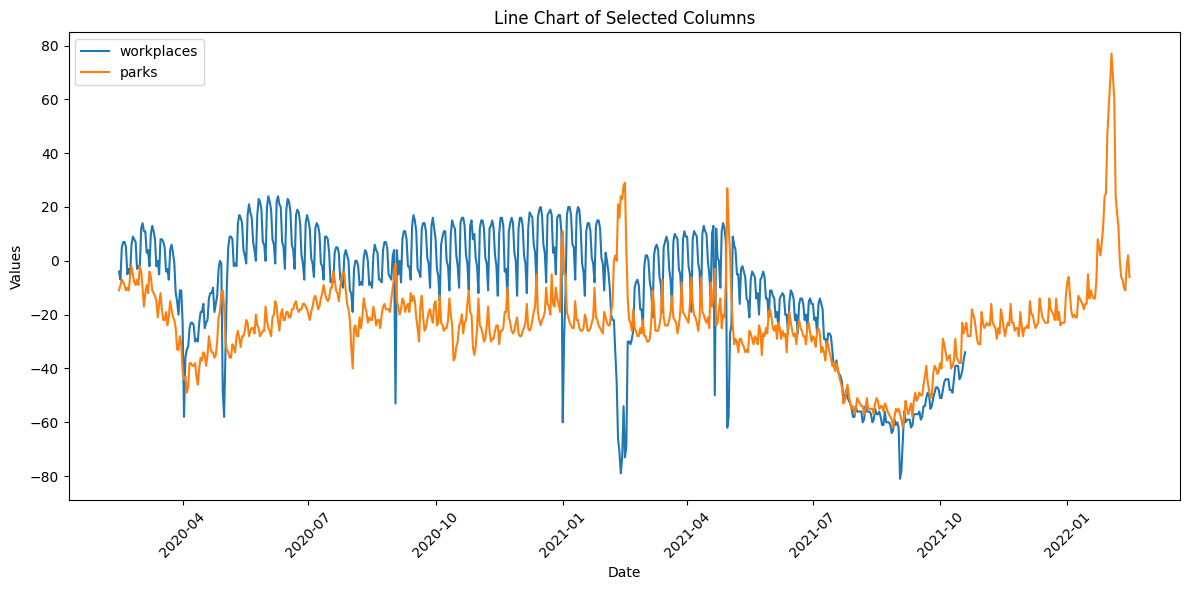

In [117]:
print("Vietnam")
graph_columns(vietnam,'Date', ['workplaces', 'parks'], "line")

Gabon


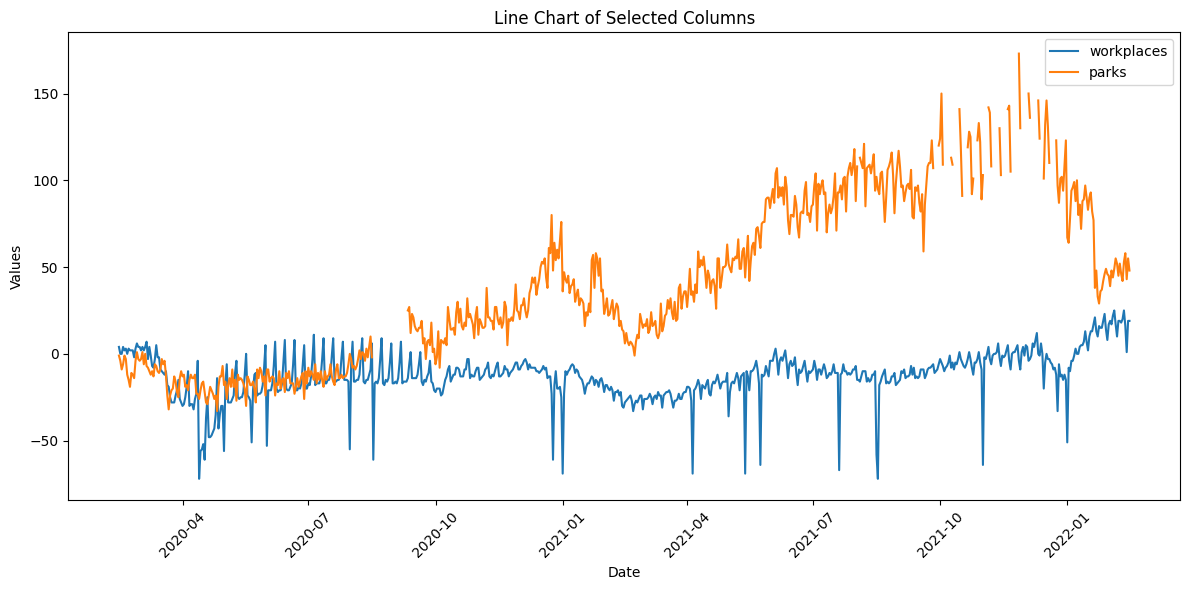

In [118]:
print("Gabon")
graph_columns(gabon, 'Date', ['workplaces', 'parks'], "line")

Based on the graphs, workplace data may not have been collected since around the last quarter of 2021 and parks are missing in some dates in Gabon. In addition, there seems to be a high degrea of day to day variabilty within the week as noticed by our reference study. With this I would use weekly median value to address the variability and might also address the missing values

### Get the weekly median for the mobility values

In [119]:
# 1. Extract year and week number from the 'date' column
# Using isocalendar() is the recommended way as it handles week boundaries correctly
# This adds new columns 'year' and 'week'
filtered_mobility_with_week = filtered_mobility.assign(
    year=filtered_mobility['Date'].dt.isocalendar().year,
    week=filtered_mobility['Date'].dt.isocalendar().week
)

# Create the combined 'year_and_week' column (e.g., "2020-W01")
# Using string formatting for clarity and consistency
filtered_mobility_with_week = filtered_mobility_with_week.assign(
    year_and_week=(
        filtered_mobility_with_week['year'].astype(str) +
        "-W" +
        filtered_mobility_with_week['week'].astype(str).str.zfill(2) # Pad week with leading zero
    )
)

# 2. Define the mobility columns to aggregate
mobility_cols = [
    'retail_and_recreation',
    'grocery_and_pharmacy',
    'parks',
    'transit_stations',
    'workplaces',
    'residential'
]

# 3. Group by Country, Code, and year_and_week, then calculate the median for mobility columns
# Select the relevant columns for grouping and aggregation
grouping_cols = ['Country', 'Code', 'year_and_week']
aggregation_dict = {col: 'median' for col in mobility_cols}

median_mobility_by_week = (
    filtered_mobility_with_week[grouping_cols + mobility_cols]
    .groupby(grouping_cols)
    .agg(aggregation_dict, split_out=1) # split_out can help with performance on large groups
    # .median() # Alternative to .agg(), but .agg() is more explicit for multiple columns
)

# 4. Reset index to make 'Country', 'Code', 'year_and_week' regular columns
median_mobility_by_week = median_mobility_by_week.reset_index()

# 5. Compute the result (triggers Dask execution)
# The result will be a pandas DataFrame
weekly_mobility = median_mobility_by_week.compute()

# Display the final result
print("Median mobility values by Country, Code, and Year-Week:")
print(weekly_mobility.head(20)) # Show first 20 rows as an example


Median mobility values by Country, Code, and Year-Week:
   Country Code year_and_week  retail_and_recreation  grocery_and_pharmacy  \
0    Japan  JPN      2020-W09                   -3.0                   7.0   
1    Japan  JPN      2020-W10                  -10.0                   2.0   
2    Japan  JPN      2020-W11                   -7.0                   3.0   
3    Japan  JPN      2020-W12                   -3.0                   4.0   
4    Japan  JPN      2020-W14                  -14.0                   6.0   
5    Japan  JPN      2020-W18                  -35.0                  -5.0   
6    Japan  JPN      2020-W19                  -34.0                  -5.0   
7    Japan  JPN      2020-W20                  -32.0                  -1.0   
8    Japan  JPN      2020-W21                  -27.0                  -1.0   
9    Japan  JPN      2020-W23                  -18.0                   1.0   
10   Japan  JPN      2020-W24                  -16.0                  -1.0   
11   Jap

In [120]:
len(weekly_mobility)

11862

In [121]:
# Check missing data patterns
missing_counts = weekly_mobility.isnull().sum()
missing_percent = (missing_counts / len(weekly_mobility)) * 100

print("Missing data percentage:")
for col, pct in missing_percent.items():
    print(f"{col}: {pct:.2f}%")

Missing data percentage:
Country: 0.00%
Code: 0.00%
year_and_week: 0.00%
retail_and_recreation: 0.18%
grocery_and_pharmacy: 0.13%
parks: 0.46%
transit_stations: 0.34%
workplaces: 0.14%
residential: 0.00%


In [122]:
# Note: For pandas groupby.apply, we don't use the 'meta' argument.
missing_percent_per_group = (
    weekly_mobility
    .groupby(['Country', 'Code'])  # Group the pandas DataFrame by 'Country' and 'Code'
    .apply(              # Apply a function to each group
        lambda group: (group.isnull().sum() / len(group)) * 100
        # Do NOT include meta=... here for pandas
    )
    # No .compute() needed for pandas operations
)

# Filter the result to show only groups with at least one column having missing data
# A group has missing data if the maximum missing percentage across its columns is greater than 0
countries_with_missing = missing_percent_per_group[
    missing_percent_per_group.max(axis=1) > 0
]

sorted_by_max_missing = countries_with_missing.loc[countries_with_missing.max(axis=1).sort_values(ascending=False).index]

# Display the results for groups with missing data
if not countries_with_missing.empty:
    print("Missing data percentage per Country-Code group (Groups with ANY missing data):")
    print(sorted_by_max_missing)
else:
    print("No Country-Code groups found with missing data in any column.")


Missing data percentage per Country-Code group (Groups with ANY missing data):
                       Country  Code  year_and_week  retail_and_recreation  \
Country          Code                                                        
Vietnam          VNM       0.0   0.0            0.0               0.000000   
Angola           AGO       0.0   0.0            0.0               0.000000   
Benin            BEN       0.0   0.0            0.0               0.000000   
Barbados         BRB       0.0   0.0            0.0               0.000000   
Botswana         BWA       0.0   0.0            0.0               2.830189   
Burkina Faso     BFA       0.0   0.0            0.0               0.000000   
Gabon            GAB       0.0   0.0            0.0               2.830189   
Cape Verde       CPV       0.0   0.0            0.0               2.830189   
Luxembourg       LUX       0.0   0.0            0.0               0.000000   
Mali             MLI       0.0   0.0            0.0            

/tmp/ipykernel_931/2281753613.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(              # Apply a function to each group


Vietnam still has attribute that has more that 16% missing so I will remove it for the analysis. There are still countries that have missing values in some of their parameters. I will check Botswana as it has 2.83% missing in three of its parameters

In [124]:
to_keep = study_sample['Code'] != "VNM"
study_sample = study_sample[to_keep]
weekly_mobility = weekly_mobility[weekly_mobility['Code'].isin(study_sample['Code'])]
print(weekly_mobility)

      Country Code year_and_week  retail_and_recreation  grocery_and_pharmacy  \
0       Japan  JPN      2020-W09                   -3.0                   7.0   
1       Japan  JPN      2020-W10                  -10.0                   2.0   
2       Japan  JPN      2020-W11                   -7.0                   3.0   
3       Japan  JPN      2020-W12                   -3.0                   4.0   
4       Japan  JPN      2020-W14                  -14.0                   6.0   
...       ...  ...           ...                    ...                   ...   
11857  Jordan  JOR      2021-W48                   15.0                  50.0   
11858  Jordan  JOR      2021-W52                   16.0                  47.0   
11859  Jordan  JOR      2022-W01                   11.0                  46.0   
11860  Jordan  JOR      2022-W03                    0.0                  33.0   
11861  Jordan  JOR      2022-W07                   11.5                  41.5   

       parks  transit_stati

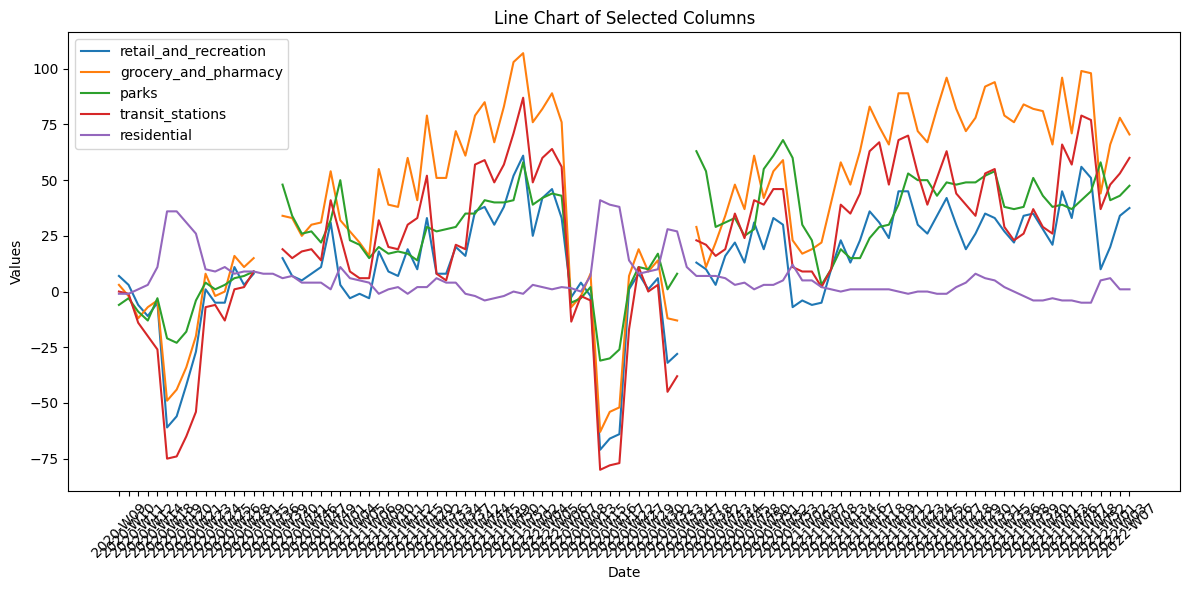

In [132]:
# Check Botswana
country_to_check = weekly_mobility[weekly_mobility['Code'] == 'BWA']
graph_columns(country_to_check, 'year_and_week', ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'residential'], "line")

Missing Data Handling: We identified short-term missing data periods (<3% of observations per country) in mobility variables, typically lasting 1-3 consecutive weeks. Given the low frequency and short duration of these gaps, we employed linear interpolation within each country to maintain data integrity while preserving sample size. This approach is appropriate because: (1) mobility patterns exhibit temporal smoothness, (2) the missing data percentage is minimal, and (3) interpolation preserves the temporal correlation structure of the data. We validated interpolated values to ensure they remained within reasonable bounds relative to surrounding observations.

### Interpolate missing values

In [134]:
def simple_mobility_interpolation(df):
    """Simple and robust interpolation for your mobility data"""
    
    # Define mobility variables
    mobility_variables = [
        'retail_and_recreation',
        'grocery_and_pharmacy',
        'parks',
        'transit_stations',
        'workplaces',
        'residential'
    ]
    
    # Create result dataframe
    result_df = df.copy()
    
    print("Starting interpolation...")
    print(f"Original missing values: {result_df[mobility_variables].isnull().sum().sum()}")
    
    # Interpolate each variable using groupby transform (most reliable method)
    for var in mobility_variables:
        if var in result_df.columns:
            print(f"Interpolating {var}...")
            # This is the most robust approach for group-wise interpolation
            result_df[var] = result_df.groupby(['Country', 'Code'])[var].transform(
                lambda x: x.interpolate(method='linear', limit_direction='both')
            )
    
    # Handle any remaining NAs (countries with all missing values for a variable)
    for var in mobility_variables:
        if var in result_df.columns:
            result_df[var] = result_df[var].fillna(method='ffill').fillna(method='bfill')
    
    final_missing = result_df[mobility_variables].isnull().sum().sum()
    print(f"Final missing values: {final_missing}")
    print("Interpolation complete!")
    
    return result_df

# Apply the simpler approach
interpolated_mobility_data = simple_mobility_interpolation(weekly_mobility)

Starting interpolation...
Original missing values: 130
Interpolating retail_and_recreation...
Interpolating grocery_and_pharmacy...
Interpolating parks...
Interpolating transit_stations...
Interpolating workplaces...
Interpolating residential...
Final missing values: 0
Interpolation complete!


In [135]:
# Check missing data patterns
missing_counts = interpolated_mobility_data.isnull().sum()
missing_percent = (missing_counts / len(interpolated_mobility_data)) * 100

print("Missing data percentage:")
for col, pct in missing_percent.items():
    print(f"{col}: {pct:.2f}%")

Missing data percentage:
Country: 0.00%
Code: 0.00%
year_and_week: 0.00%
retail_and_recreation: 0.00%
grocery_and_pharmacy: 0.00%
parks: 0.00%
transit_stations: 0.00%
workplaces: 0.00%
residential: 0.00%


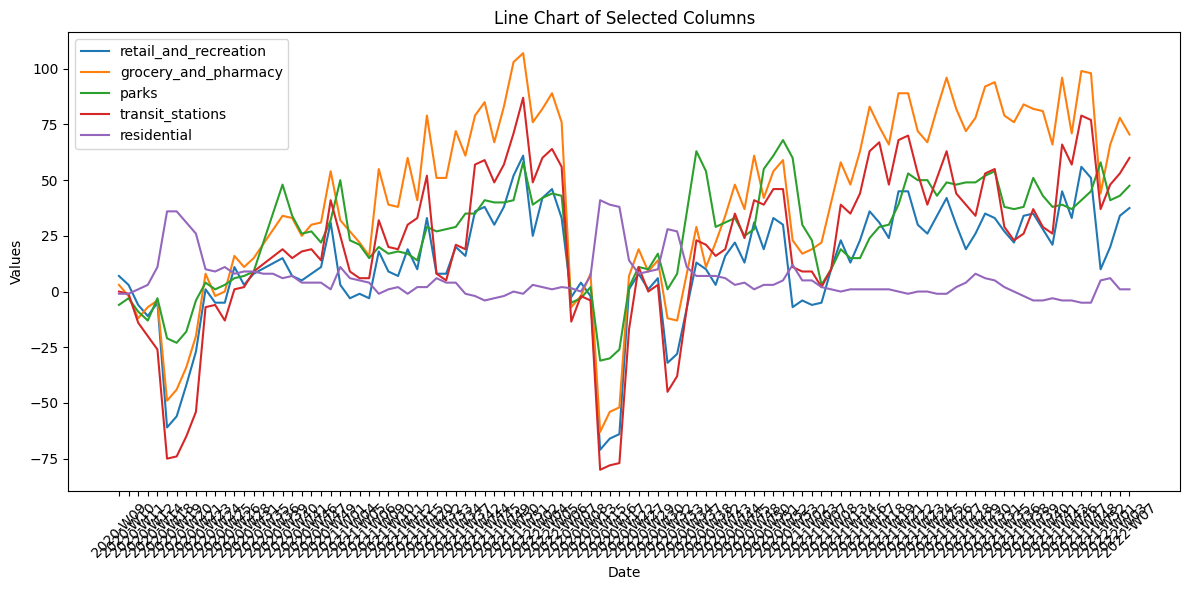

In [137]:
# Check Botswana
country_to_check = interpolated_mobility_data[interpolated_mobility_data['Code'] == 'BWA']
graph_columns(country_to_check, 'year_and_week', ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'residential'], "line")

## Checking for outliers

In [139]:
# Check for extreme values in mobility variables
mobility_cols = [
    'retail_and_recreation',
    'grocery_and_pharmacy',
    'parks', 
    'transit_stations',
    'workplaces',
    'residential'
]

# Compute quantiles for outlier detection
for col in mobility_cols:
    quantiles = interpolated_mobility_data[col].quantile([0.01, 0.25, 0.50, 0.75, 0.99])
    print(f"{col} - 1st percentile: {quantiles[0.01]:.2f}, 1st quartile:{quantiles[0.25]:0.2f}, median:{quantiles[0.50]:0.2f}, 3rd quartile:{quantiles[0.75]:0.2f}, 99th percentile: {quantiles[0.99]:.2f}")
    
    # Winsorize extreme values or set reasonable bounds
    # Mobility changes rarely exceed ±100%
    #filtered_mobility[col] = filtered_mobility[col].clip(lower=-100, upper=100)

retail_and_recreation - 1st percentile: -78.00, 1st quartile:-26.00, median:-10.00, 3rd quartile:3.00, 99th percentile: 70.00
grocery_and_pharmacy - 1st percentile: -54.45, 1st quartile:-5.00, median:5.00, 3rd quartile:22.00, 99th percentile: 120.00
parks - 1st percentile: -67.00, 1st quartile:-19.00, median:-1.00, 3rd quartile:27.00, 99th percentile: 193.00
transit_stations - 1st percentile: -77.00, 1st quartile:-35.00, median:-17.00, 3rd quartile:1.00, 99th percentile: 67.00
workplaces - 1st percentile: -68.00, 1st quartile:-29.00, median:-18.00, 3rd quartile:-6.00, 99th percentile: 36.45
residential - 1st percentile: -10.00, 1st quartile:1.00, median:6.00, 3rd quartile:11.00, 99th percentile: 32.00


In [143]:
outlier_threshold = 100

# 2. Initialize a dictionary to store results for each column
countries_with_outliers = {}

# 3. Check each mobility column for outliers and get max values
for column in mobility_cols:
    # Filter the DataFrame to rows where the value exceeds the threshold
    df_outliers_for_column = interpolated_mobility_data[
        interpolated_mobility_data[column] > outlier_threshold
    ]

    # If there are outliers, find the max value and corresponding country code for each country
    if not df_outliers_for_column.empty:
        # Group by 'Code' and find the maximum value for this column within each group
        max_values_per_country = (
            df_outliers_for_column.groupby('Code')[column].max().reset_index()
        )
        # Convert to list of tuples (Country_Code, Max_Value)
        countries_with_outliers[column] = list(
            max_values_per_country.itertuples(index=False, name=None)
        )
    else:
        countries_with_outliers[column] = []

# 4. Display the results
print(f"Countries with outlier values (>{outlier_threshold}) in each mobility parameter:")
print("-" * 80)
for column, country_data_list in countries_with_outliers.items():
    # Extract the base name of the column for cleaner display (optional)
    # display_name = column.replace('_percent_change_from_baseline', '')
    print(f"\n{column}:")

    if country_data_list:
        # Sort the list by Country Code for consistent output
        for country_code, max_value in sorted(country_data_list, key=lambda x: x[0]):
            print(f"  - {country_code}: {max_value:.2f}")
    else:
        print("  - None found")




Countries with outlier values (>100) in each mobility parameter:
--------------------------------------------------------------------------------

retail_and_recreation:
  - IRQ: 103.00
  - MNG: 103.00
  - YEM: 106.00

grocery_and_pharmacy:
  - BEN: 129.00
  - BFA: 181.00
  - BWA: 107.00
  - CIV: 135.00
  - EGY: 118.00
  - IRQ: 172.00
  - MAR: 105.00
  - MNG: 194.00
  - NPL: 122.00
  - PNG: 120.00
  - YEM: 127.00
  - ZWE: 105.00

parks:
  - AGO: 102.50
  - AUT: 152.00
  - BEL: 142.00
  - BEN: 138.00
  - BFA: 143.00
  - BGR: 111.00
  - CAN: 183.00
  - CHE: 152.00
  - CZE: 134.00
  - DEU: 156.00
  - DNK: 389.00
  - ESP: 102.00
  - EST: 236.00
  - FIN: 368.00
  - FRA: 241.00
  - GAB: 151.50
  - GBR: 113.00
  - GRC: 308.00
  - HRV: 610.00
  - HUN: 170.00
  - IRL: 131.00
  - ITA: 209.00
  - LTU: 226.00
  - LUX: 161.00
  - LVA: 195.00
  - MLI: 150.50
  - MNG: 101.00
  - NLD: 251.00
  - NOR: 250.00
  - POL: 212.00
  - PRT: 160.00
  - SVK: 186.00
  - SVN: 221.00
  - SWE: 367.00
  - TGO: 135.00

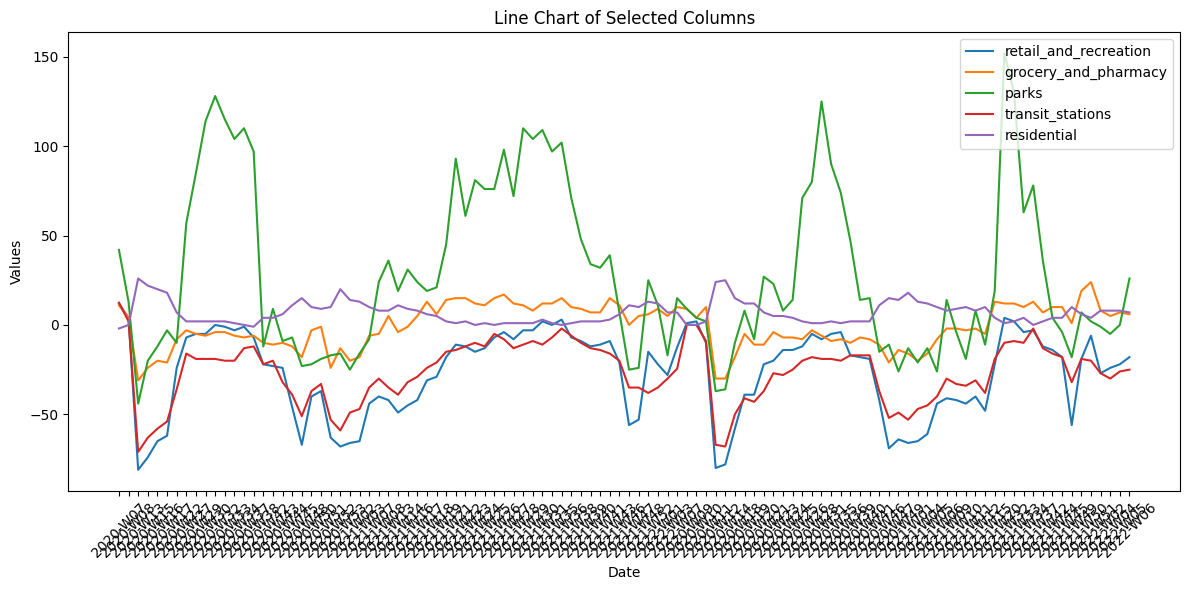

In [145]:
# Check Botswana
country_to_check = interpolated_mobility_data[interpolated_mobility_data['Code'] == 'AUT']
graph_columns(country_to_check, 'year_and_week', ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'residential'], "line")

Great question! Looking at your distributions, I can see some notable outliers, especially in grocery_and_pharmacy (120%) and parks (193%). Let me help you manage these outliers and understand their impact on your composite mobility variable.

Identifying Problematic Outliers
Extreme Values Analysis:
Parks: 99th percentile = 193% (very extreme!)
Grocery & Pharmacy: 99th percentile = 120% (quite high)
Others: Within reasonable ranges (-78% to 67%)
Recommended Approach: Winsorization
Winsorization is the best approach because it:

Caps extreme values rather than removing them
Preserves sample size
Maintains data distribution shape
Reduces influence on composite index

In [152]:
def manage_mobility_outliers(df):
    """Manage outliers in mobility data using winsorization"""
    
    # Define reasonable caps based on your distributions
    outlier_caps = {
        'retail_and_recreation': (-80, 75),    # Slightly beyond 1st/99th percentiles
        'grocery_and_pharmacy': (-60, 100),     # Cap the 120% extreme values
        'parks': (-70, 150),                   # Significantly cap the 193% values
        'transit_stations': (-80, 70),
        'workplaces': (-70, 40),
        'residential': (-15, 35)
    }
    
    df_cleaned = df.copy()
    
    print("Managing outliers...")
    print("Variable                    Before Cap Range   After Cap Range    Observations Capped")
    print("-" * 75)
    
    for var, (lower_cap, upper_cap) in outlier_caps.items():
        if var in df_cleaned.columns:
            # Count observations that will be capped
            below_count = (df_cleaned[var] < lower_cap).sum()
            above_count = (df_cleaned[var] > upper_cap).sum()
            total_capped = below_count + above_count
            
            # Apply winsorization
            df_cleaned[var] = df_cleaned[var].clip(lower=lower_cap, upper=upper_cap)
            
            # Show impact
            if total_capped > 0:
                print(f"{var:<30} [{df[var].min():4.0f}, {df[var].max():4.0f}]    [{lower_cap:4.0f}, {upper_cap:4.0f}]    {total_capped:>6}")
    
    return df_cleaned

# Apply outlier management
mobility_data_cleaned = manage_mobility_outliers(interpolated_mobility_data)

Managing outliers...
Variable                    Before Cap Range   After Cap Range    Observations Capped
---------------------------------------------------------------------------
retail_and_recreation          [ -92,  106]    [ -80,   75]       180
grocery_and_pharmacy           [ -87,  194]    [ -60,  100]       312
parks                          [ -93,  610]    [ -70,  150]       349
transit_stations               [ -92,  132]    [ -80,   70]       141
workplaces                     [ -87,   92]    [ -70,   40]       156
residential                    [ -15,   44]    [ -15,   35]        57


In [153]:
len(interpolated_mobility_data)

11756

In [150]:
# Compute quantiles for outlier detection
for col in mobility_cols:
    quantiles = interpolated_mobility_data[col].quantile([0.01, 0.25, 0.50, 0.75, 0.99])
    print(f"{col} - 1st percentile: {quantiles[0.01]:.2f}, 1st quartile:{quantiles[0.25]:0.2f}, median:{quantiles[0.50]:0.2f}, 3rd quartile:{quantiles[0.75]:0.2f}, 99th percentile: {quantiles[0.99]:.2f}")

retail_and_recreation - 1st percentile: -78.00, 1st quartile:-26.00, median:-10.00, 3rd quartile:3.00, 99th percentile: 70.00
grocery_and_pharmacy - 1st percentile: -54.45, 1st quartile:-5.00, median:5.00, 3rd quartile:22.00, 99th percentile: 120.00
parks - 1st percentile: -67.00, 1st quartile:-19.00, median:-1.00, 3rd quartile:27.00, 99th percentile: 193.00
transit_stations - 1st percentile: -77.00, 1st quartile:-35.00, median:-17.00, 3rd quartile:1.00, 99th percentile: 67.00
workplaces - 1st percentile: -68.00, 1st quartile:-29.00, median:-18.00, 3rd quartile:-6.00, 99th percentile: 36.45
residential - 1st percentile: -10.00, 1st quartile:1.00, median:6.00, 3rd quartile:11.00, 99th percentile: 32.00
